## imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

In [ ]:
import tensorflow.keras.backend as K

In [ ]:
from keras import layers

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import IPython.display as disp

In [ ]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#for colab
!unzip -u "/content/drive/My Drive/KCDH2024_Training_Input_10K_Organized.zip" -d "/content/drive/My Drive/KCDH2024_Training_Input_10K_Organized/"

unzip:  cannot find or open /content/drive/My Drive/KCDH2024_Training_Input_10K_Organized.zip, /content/drive/My Drive/KCDH2024_Training_Input_10K_Organized.zip.zip or /content/drive/My Drive/KCDH2024_Training_Input_10K_Organized.zip.ZIP.


## DATA


### Loading Head and Tail Separately

In [ ]:
orig_image_size = (600,450)
image_size=(360,270)
batch_size=None

def normalize_image(image, label):
    image=tf.cast(image, tf.float32)/255.0
    image=tf.image.resize(image,image_size)
    return image,label

def head_map(image, label):
    return image, tf.cond(tf.equal(label,0), lambda: tf.constant(5), lambda: tf.constant(0))

def middle_map(image, label):
    return image, tf.cond(tf.equal(label, 0), lambda: tf.constant(2),
                lambda: tf.cond(tf.equal(label, 1), lambda: tf.constant(4),
                lambda: tf.constant(0)))

def tail_map(image, label):
    return image, tf.cond(tf.equal(label, 0), lambda: tf.constant(3),
                lambda: tf.cond(tf.equal(label, 1), lambda: tf.constant(6),
                lambda: tf.cond(tf.equal(label, 2), lambda: tf.constant(0),
                lambda: tf.constant(1))))

class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
head_class = ['nv']
middle_class = ['bkl','mel']
tail_class = ['df','vasc','akiec','bcc']

#for jupyter
#data_dir = "Dataset/KCDH2024_Training_Input_10K_Organized/"

#for colab
data_dir = "/content/drive/My Drive/KCDH2024_Training_Input_10K_Organized/KCDH2024_Training_Input_10K_Organized/"


head_data = keras.utils.image_dataset_from_directory( data_dir + "head/",
                                                    class_names=head_class,
                                                         image_size=image_size,
                                                   color_mode="rgb",
                                                   shuffle=True,
                                                     validation_split=0.1,
                                                     seed=0,
                                                     subset='training',
                                                    batch_size=batch_size)
head_datav = keras.utils.image_dataset_from_directory( data_dir + 'head/',
                                                    class_names=head_class,
                                                         image_size=image_size,
                                                   color_mode="rgb",
                                                   shuffle=True,
                                                     validation_split=0.1,
                                                     seed=0,
                                                     subset='validation',
                                                    batch_size=batch_size)


middle_data = keras.utils.image_dataset_from_directory( data_dir + 'middle/',
                                                    class_names=middle_class,
                                                         image_size=image_size,
                                                   color_mode="rgb",
                                                   shuffle=True,
                                                       validation_split=0.1,
                                                     seed=0,
                                                     subset='training',
                                                    batch_size=batch_size)
middle_datav = keras.utils.image_dataset_from_directory( data_dir + 'middle/',
                                                    class_names=middle_class,
                                                         image_size=image_size,
                                                   color_mode="rgb",
                                                   shuffle=True,
                                                       validation_split=0.1,
                                                     seed=0,
                                                     subset='validation',
                                                    batch_size=batch_size)

tail_data = keras.utils.image_dataset_from_directory( data_dir + 'tail/',
                                                    class_names=tail_class,
                                                         image_size=image_size,
                                                   color_mode="rgb",
                                                   shuffle=True,
                                                     validation_split=0.1,
                                                     seed=0,
                                                     subset='training',
                                                    batch_size=batch_size)
tail_datav = keras.utils.image_dataset_from_directory( data_dir + 'tail/',
                                                    class_names=tail_class,
                                                         image_size=image_size,
                                                   color_mode="rgb",
                                                   shuffle=True,
                                                     validation_split=0.1,
                                                     seed=0,
                                                     subset='validation',
                                                    batch_size=batch_size)

data_test = keras.utils.image_dataset_from_directory( data_dir + 'test/'
                                                    class_names=class_names
                                                         image_size=image_size,
                                                   color_mode="rgb",
                                                   shuffle=True,
                                                     seed=0,
                                                    batch_size=batch_size)

head_data=head_data.map(normalize_image).map(head_map)
middle_data=middle_data.map(normalize_image).map(middle_map)
tail_data=tail_data.map(normalize_image).map(tail_map)
head_datav=head_datav.map(normalize_image).map(head_map)
middle_datav=middle_datav.map(normalize_image).map(middle_map)
tail_datav=tail_datav.map(normalize_image).map(tail_map)

In [ ]:
data_hm = head_data.concatenate(middle_data)
data_hmv = head_datav.concatenate(middle_datav)

data_mt = middle_data.concatenate(tail_data)
data_mtv = middle_datav.concatenate(tail_datav)

dataset_train = data_hm.concatenate(tail_data)
dataset_valid = data_hmv.concatenate(tail_datav)

'data_hm = head_data.concatenate(middle_data)\ndata_hmv = head_datav.concatenate(middle_datav)\n\ndata_mt = middle_data.concatenate(tail_data)\ndata_mtv = middle_datav.concatenate(tail_datav)\n\ndataset_train = data_hm.concatenate(tail_data)\ndataset_valid = data_hmv.concatenate(tail_datav)'

### Data Augmentation

In [ ]:
def data_augmentation(img,label):
    img=layers.RandomFlip("horizontal_and_vertical")(img)
    img=layers.RandomRotation(1)(img)
    return img,label


### Count class frequency

In [ ]:
train_freq = [0,0,0,0,0,0,0]
valid_freq = [0,0,0,0,0,0,0]
inverse_freq=[0,0,0,0,0,0,0]
test_freq = [0,0,0,0,0,0,0]

for img in dataset_train:
    train_freq[img[1]] += 1

for img in dataset_valid:
    valid_freq[img[1]] += 1

for img in data_test:
    test_freq[img[1]] += 1

for i in range(7):
    inverse_freq[i]=1./max(train_freq[i],1)

In [ ]:
x=np.array(class_names)
y=np.array(train_freq)

plt.bar(x,y)
plt.title("train split")
plt.show()

x=np.array(class_names)
y=np.array(valid_freq)

plt.bar(x,y)
plt.title("valid split")
plt.show()

### Data Pipeline

In [ ]:
print(head_data)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 360, 270, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
def shuffle_and_batch(dataset):
    #dataset = dataset.filter(lambda x, y: tf.size(x) > 0)
    return dataset.shuffle(5000).batch(16, drop_remainder=False)

dataset_train = shuffle_and_batch(dataset_train)
dataset_valid = shuffle_and_batch(dataset_valid)
head_data = shuffle_and_batch(head_data)
middle_data = shuffle_and_batch(middle_data)
tail_data = shuffle_and_batch(tail_data)
head_datav = shuffle_and_batch(head_datav)
middle_datav = shuffle_and_batch(middle_datav)
tail_datav = shuffle_and_batch(tail_datav)
data_hm = shuffle_and_batch(data_hm)
data_hmv = shuffle_and_batch(data_hmv)
data_mt = shuffle_and_batch(data_mt)
data_mtv = shuffle_and_batch(data_mtv)

In [ ]:
print(tail_datav)

### Testing Dataset

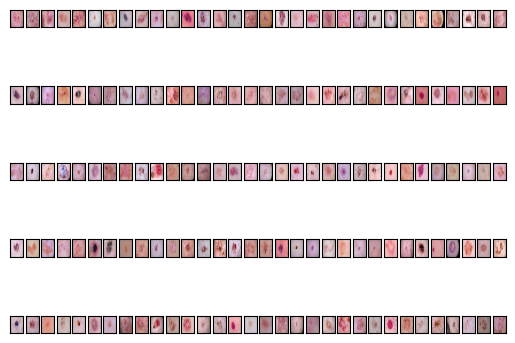

In [ ]:
from time import sleep

fig, axs = plt.subplots(5,32)

counter = 0
for imgs,label in tail_data:
  counter1 = 0
  if(counter == 5):
    break
  for img in imgs:
    axs[counter, counter1].imshow(img)
    axs[counter, counter1].get_xaxis().set_visible(False)
    axs[counter, counter1].get_yaxis().set_visible(False)
    counter1 += 1
  counter += 1


## Model

### Metrics

#### Balanced Accuracy Class

In [ ]:
class BalancedSparseCategoricalAccuracy(keras.metrics.Metric):

    def __init__(self, name='balanced_sparse_categorical_accuracy', **kwargs):
        super(BalancedSparseCategoricalAccuracy, self).__init__(**kwargs)

        self.correct_count = tf.Variable([0,0,0,0,0,0,0])
        self.total_count = tf.Variable([0,0,0,0,0,0,0])
        self.accuracy = 0.0
        self.quotient = tf.Variable([0.,0.,0.,0.,0.,0.,0.])

    def reset_state(self):
        self.correct_count = tf.Variable([0,0,0,0,0,0,0])
        self.total_count = tf.Variable([0,0,0,0,0,0,0])
        self.quotient = tf.Variable([0.,0.,0.,0.,0.,0.,0.])
        self.accuracy = 0.0

    def update_state(self, y_true, y_pred, sample_weight=None):
        pred_idx = tf.argmax(y_pred, axis=1, output_type=tf.int32)
        y_true=tf.reshape(y_true, tf.shape(pred_idx))
        y_true=tf.cast(y_true,tf.int32)

        def count_all(y_true):
            return tf.cast([ tf.reduce_sum(tf.cast(tf.equal(y_true,i),tf.float32)) for i in range(0,7)],tf.int32)

        def count_match(y_true, y_pred):
             return tf.cast([ tf.reduce_sum(tf.cast(tf.equal(y_true,i)&tf.equal(y_true,pred_idx),tf.float32)) for i in range(0,7) ],tf.int32)


        total_counts = count_all(y_true)
        tf.compat.v1.assign_add(self.total_count, total_counts)

        correct_counts = count_match(y_true, y_pred)
        tf.compat.v1.assign_add(self.correct_count, correct_counts)
        self.quotient = tf.cast(self.correct_count/self.total_count, tf.float32)
        #self.accuracy = tf.reduce_mean(self.correct_count/tf.maximum(self.total_count,1))
        #return self.accuracy

    def result(self):
        #self.accuracy = tf.reduce_mean(self.correct_count/tf.maximum(self.total_count,1))
        self.accuracy = tf.reduce_sum(tf.boolean_mask(self.quotient, tf.math.is_finite(self.quotient))) / tf.cast(tf.math.count_nonzero(self.total_count),tf.float32)
        return tf.reduce_sum(self.accuracy)


### Model Architecture

In [ ]:
model = keras.Sequential([
    layers.Conv2D(1,(1,1), input_shape=(360,270,3)),
    layers.Conv2D(24,(7,7), activation='linear'),
    layers.LeakyReLU(0.01),
    layers.Conv2D(24,(7,7), activation='linear'),
    layers.LeakyReLU(0.01),
    layers.Conv2D(24,(7,7), activation='linear'),
    layers.LeakyReLU(0.01),
    layers.MaxPool2D(),
    layers.Conv2D(24,(3,3), activation='linear'),
    layers.LeakyReLU(0.01),
    layers.MaxPool2D(),
    layers.Conv2D(24,(3,3), activation='linear'),
    layers.LeakyReLU(0.01),
    layers.MaxPool2D(),
    layers.Conv2D(24,(3,3), activation='linear'),
    layers.LeakyReLU(0.01),
    layers.MaxPool2D(),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(128, activation='linear'),
    layers.LeakyReLU(0.01),
    layers.Dropout(0.1),
    layers.Dense(128, activation='linear'),
    layers.LeakyReLU(0.01),
    layers.Dropout(0.1),
    layers.Dense(7, activation='softmax')

])

model.build()

In [ ]:
model=keras.models.load_model("/content/drive/My Drive/tail_model.keras", custom_objects={"BalancedSparseCategoricalAccuracy" : BalancedSparseCategoricalAccuracy()})

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 360, 270, 1)       4         
                                                                 
 conv2d_36 (Conv2D)          (None, 354, 264, 24)      1200      
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 354, 264, 24)      0         
                                                                 
 conv2d_37 (Conv2D)          (None, 348, 258, 24)      28248     
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 348, 258, 24)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 342, 252, 24)      28248     
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 342, 252, 24)     

### Model Training

In [ ]:
total_history = []

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0007),
    loss = 'sparse_categorical_crossentropy',
    metrics = [BalancedSparseCategoricalAccuracy(), 'accuracy']
)

In [ ]:
# Early stopping to stop training when loss stops to decrease
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience = 5)

In [ ]:
history = model.fit(middle_data,
                         epochs=20,
                         shuffle=True,
                         validation_data=middle_datav,
                         callbacks = [es],
                        )

total_history.append(history)

Epoch 1/20
117/117 [==============================] - 59s 254ms/step - loss: 3.6372 - balanced_sparse_categorical_accuracy_2: 0.5622 - accuracy: 0.5631 - val_loss: 0.6379 - val_balanced_sparse_categorical_accuracy_2: 0.6563 - val_accuracy: 0.6522
Epoch 2/20
117/117 [==============================] - 38s 193ms/step - loss: 0.5929 - balanced_sparse_categorical_accuracy_2: nan - accuracy: 0.6892 - val_loss: 0.6293 - val_balanced_sparse_categorical_accuracy_2: nan - val_accuracy: 0.6329
Epoch 3/20
117/117 [==============================] - 36s 188ms/step - loss: 0.5729 - balanced_sparse_categorical_accuracy_2: nan - accuracy: 0.7085 - val_loss: 0.6473 - val_balanced_sparse_categorical_accuracy_2: nan - val_accuracy: 0.6087
Epoch 4/20
117/117 [==============================] - 37s 188ms/step - loss: 0.5591 - balanced_sparse_categorical_accuracy_2: nan - accuracy: 0.7075 - val_loss: 0.6351 - val_balanced_sparse_categorical_accuracy_2: nan - val_accuracy: 0.6135
Epoch 5/20
117/117 [==========

In [ ]:
model.save("/content/drive/My Drive/tail_model.keras")

In [ ]:
y1=[]
y2=[]

for hist in total_history:
  y2.extend(hist.history['loss'])
  y1.extend(hist.history['val_loss'])

plt.plot(y1)
plt.plot(y2)
plt.legend(['val loss', 'loss'])
plt.show()

## Model Testing

In [ ]:
predictions=model.predict(data_train)

In [ ]:
print(predictions)

[[9.46757756e-03 4.07480169e-03 8.45122993e-01 2.85785948e-03
  1.29599571e-01 4.00459813e-03 4.87258518e-03]
 [2.20993516e-05 3.13463852e-06 8.40397894e-01 2.57021952e-06
  1.59565598e-01 3.69822988e-06 4.94967480e-06]
 [2.17124325e-04 1.01694073e-04 7.59424686e-01 5.84502013e-05
  2.39964202e-01 8.87802307e-05 1.44957303e-04]
 [1.27451215e-03 3.01165885e-04 3.93311530e-01 1.89343045e-04
  6.04080617e-01 3.69442627e-04 4.73312743e-04]
 [6.27481786e-05 9.03274395e-06 5.18460870e-01 4.23297661e-06
  4.81412530e-01 1.35559540e-05 3.70962844e-05]
 [1.76881591e-03 2.74566904e-04 6.95585072e-01 4.89504833e-04
  3.00493062e-01 4.18566342e-04 9.70445573e-04]
 [3.02296048e-05 4.43717727e-06 6.50416315e-01 4.88854448e-06
  3.49524856e-01 7.31255795e-06 1.19584165e-05]
 [1.27039995e-04 1.95390039e-05 7.37241030e-01 1.90960691e-05
  2.62542188e-01 2.56974508e-05 2.53892995e-05]
 [3.59926431e-04 9.96387098e-05 7.85807610e-01 6.66749766e-05
  2.13432401e-01 8.18471453e-05 1.51865563e-04]
 [8.143052

In [ ]:
predictions=np.asarray(predictions)
class_pred=[]
for i in predictions:
    class_pred.append(tf.math.argmax(i))
class_pred=np.asarray(class_pred)

count=[0,0,0,0,0,0,0]
for i in class_pred:
    count[i] += 1

X_Axis=np.arange(len(class_names))
plt.xticks(X_Axis,class_names)
width=0.3

plt.bar(X_Axis, count, width, label="predictions")
#plt.bar(X_Axis+width, valid_freq, width, label="ground truth")
plt.legend()
plt.show()

In [ ]:
grd_truth=[]

for batch in tail_datav:
    val=np.asarray(batch[1])
    grd_truth.extend(val)

class_acc=[0,0,0,0,0,0,0]
class_cnt = [0,0,0,0,0,0,0]

for i,j in zip(class_pred,grd_truth):
    if(i==j):
        class_acc[j] += 1.
    class_cnt[j] += 1
for i in range(7):
  class_acc[i] /= max(class_cnt[i],1)
print("class wise accuracy: ", class_names,class_acc)

accuracy=(sum(class_acc)/7)

print("Balanced Accuracy=",accuracy)

In [ ]:
count=[0,0,0,0,0,0,0]
total=0
for i in range(len(grd_truth)):
  if(grd_truth[i] == 0):
    total += 1
    count[class_pred[i]] += 1

for i in range(7):
  count[i] /= total

print(count)